# 2. Multi object detection

This notebook is motivated by fast.ai's course.

In [1]:
%matplotlib inline
# % load_ext autoreload
# % autoreload 2

In [2]:
import torch
import voc
from pathlib import Path

import numpy as np
from tqdm import tqdm
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Pick one

In [3]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

### 1. Defining the datasets

The dataset objects take as input a mask, which allow me to split the data into training and validation data.

In [4]:
total_dataset = voc.datasets.VOCDataset()

Now that we know the size of the dataset, we can use this to create a mask

In [5]:
train_mask = np.random.rand(len(total_dataset)) < 0.8
val_mask = ~train_mask

In [6]:
train_images = voc.datasets.MultiImageDataset(mask=train_mask, normalizer='imagenet', 
                                         random_transform=True, resize=(224, 224), device=device)

In [7]:
label2class = train_images.get_labels_from_classes()
normalizer = train_images.get_normalizer()
class2label = {int(im_class): label for label, im_class in label2class.items()}

In [8]:
val_images = voc.datasets.MultiImageDataset(mask=val_mask, normalizer='imagenet', resize=(224, 224),
                                       label2class=label2class, device=device)

In [9]:
im, bbs, labs = train_images.__getitem__(10)

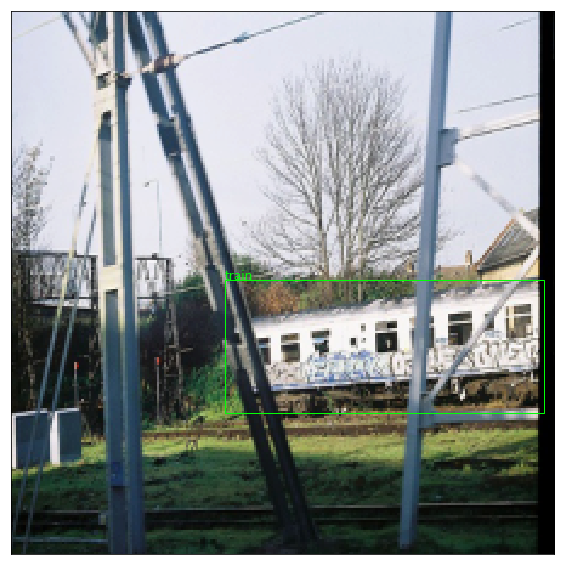

In [10]:
txt_labs = [class2label[idx.item()] for idx in labs]
denormed_im = voc.utils.denormalize(im.cpu().numpy(), mean=normalizer['mean'], std=normalizer['std'])
voc.explore.plot_image(denormed_im, bbs.cpu().numpy(), txt_labs)

Awesome. Now, in order to figure out which activations should find each of these objects, I need to do the following:

- Figure out what my **base** anchor boxes are going to be.
- Figure out what my **permuted** anchor boxes are going to be.

Then,

- Assign each ground truth bounding box to a **permuted** bounding box anchor

### 2.1. Getting the base bounding boxes, and their permutations

I am going to do this across 3 'depths', but I'll only visualize the `2 x 2` activations, to prevent the overlap from being confusing.

I'll start by considering an image of size `(1, 1)`, which I can then multiply by 224 to reflect the resnet-processed images.

In [9]:
import numpy as np

In [10]:
anchors_4 = voc.utils.make_anchors(224, 224, 0.25)
anchors_2 = voc.utils.make_anchors(224, 224, 0.5)
anchors_1 = voc.utils.make_anchors(224, 224, 1)

anchors = np.vstack((anchors_4, anchors_2, anchors_1))

Lets plot these bounding boxes, to see what they look like

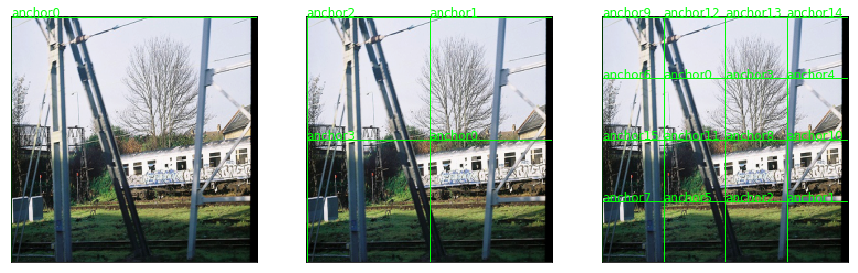

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

voc.explore.plot_image(denormed_im, anchors_1, labels=['anchor' + str(i) for i in range(len(anchors_1))], ax=ax[0])
voc.explore.plot_image(denormed_im, anchors_2, labels=['anchor' + str(i) for i in range(len(anchors_2))], ax=ax[1])
voc.explore.plot_image(denormed_im, anchors_4, labels=['anchor' + str(i) for i in range(len(anchors_4))], ax=ax[2])

Lets take a look at what these permuted anchors look like for the `2x2` boxes:

In [14]:
pm_anc_2, num_permutations = voc.utils.permute_anchors(anchors_2, zooms=[1.3, 1., 0.7], 
                                                       ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

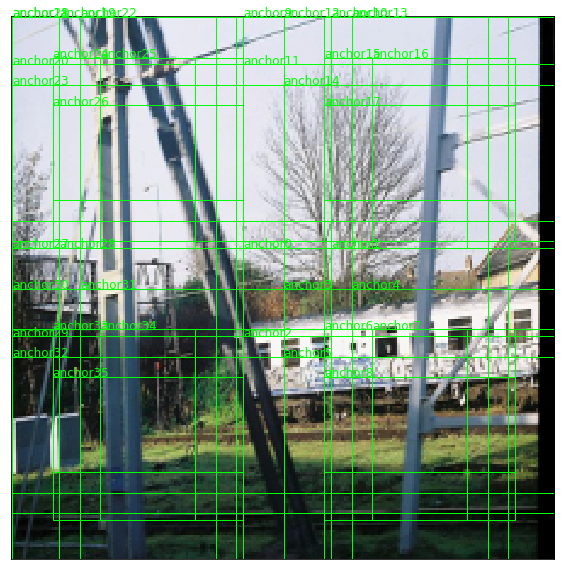

In [15]:
voc.explore.plot_image(denormed_im, pm_anc_2, labels=['anchor' + str(i) for i in range(len(pm_anc_2))])

Now, for all the boxes:

In [11]:
pm_anc, num_permutations = voc.utils.permute_anchors(anchors, zooms=[0.7, 1, 1.3], 
                                                     ratios=[(1., 1.), (0.5, 1.), (1., 0.5)])

In [12]:
num_permutations

9

In [13]:
pm_anc_tensor = torch.from_numpy(pm_anc).float().cuda()

Now that I have defined these anchor boxes, I can find the minimum and maximum learning rates

In [19]:
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [14]:
criterion = voc.models.SSDLoss(anchors=pm_anc_tensor, threshold=0.4, num_classes=len(label2class), device=device)

In [15]:
test_dataloader = DataLoader(train_images, batch_size=64, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [22]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

total_loss = []
learning_rate_progression = []

parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    
        addition = (batch_number / len(test_dataloader)) * (ending_learning_rate - starting_learning_rate)
        learning_rate = starting_learning_rate + addition
        # create a new optimizer with higher learning rates
        optimizer = torch.optim.Adam(parameters_to_update, lr=learning_rate)
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = test_ssd(ims)
        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + label_loss
        learning_rate_progression.append(learning_rate)
        total_loss.append(loss)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


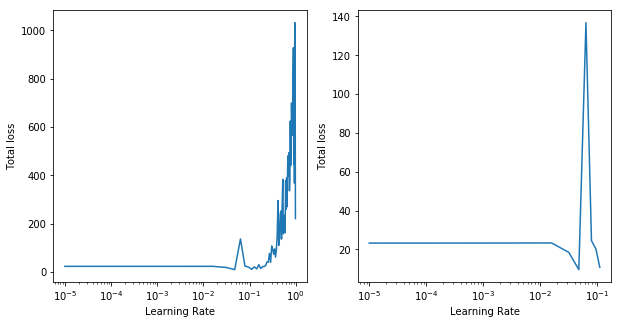

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(learning_rate_progression, total_loss)
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(learning_rate_progression[:8], total_loss[:8])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [16]:
min_lr = 1e-5
max_lr = 1e-2

In addition, I am going to find the weight (`alpha` in the SSD paper)

In [17]:
# once again, defining a test model
test_ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

                
stepsize = int(len(test_dataloader) + 1 / 2)
parameters_to_update = [parameters for name, parameters in test_ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

for batch_number, batch in (enumerate(tqdm(test_dataloader))):
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    ims, target_bb, target_label = batch
    output_bb, output_labels = test_ssd(ims)

    bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
    loss = bb_loss + label_loss
    loss.backward()
    optimizer.step()
    # note that the step happens every batch, not every epoch
    cl_scheduler.step()

100%|██████████| 63/63 [01:35<00:00,  1.51s/it]


In [18]:
loss_weight = (bb_loss / label_loss).detach()

In [19]:
loss_weight

tensor(8.3929, device='cuda:0')

Now, we can define our model, and our optimizer

In [20]:
ssd = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()

Using Xavier initialization for the non-pretrained layers

In [21]:
# initialize the weights using xavier initialization
for name, layer_weight in test_ssd.named_parameters():
    if ('pretrained' not in name) & (len(layer_weight.size()) > 1):
        torch.nn.init.xavier_uniform_(layer_weight)

In [22]:
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)
val_dataloader = DataLoader(val_images, batch_size=32, shuffle=True, collate_fn=voc.datasets.collate_im_bb_lab)

In [23]:
parameters_to_update = [parameters for name, parameters in ssd.named_parameters() if 'pretrained' not in name]
optimizer = torch.optim.Adam(parameters_to_update)

In [24]:
stepsize = int(len(train_dataloader) + 1 / 2)

In [25]:
cl_scheduler = voc.schedulers.CyclicalLR(optimizer, stepsize, min_lr, max_lr)

In [26]:
lr_change = cl_scheduler.test()

Text(0,0.5,'Learning rate')

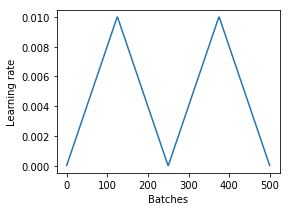

In [27]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(range(len(lr_change)), lr_change)
ax.set_xlabel('Batches')
ax.set_ylabel('Learning rate')

Finally, I can train the model

In [28]:
num_epochs = 100
patience = 5
best_val_loss = np.inf
patience_counter = 0

In [29]:
for epoch in range(num_epochs):
    # set model to train
    ssd.train()

    # Keep track of my loss, so I can display it
    running_train_scores = defaultdict(list)
    
    # Iterate through my batches
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()

        ims, target_bb, target_label = batch
        output_bb, output_labels = ssd(ims)

        bb_loss, label_loss = criterion(target_bb, target_label, output_bb, output_labels)
        loss = bb_loss + (loss_weight * label_loss)
        loss.backward()
        optimizer.step()
        # For display purposes:
        running_train_scores['loss'].append(loss.item())
        running_train_scores['bb_loss'].append(bb_loss.item())
        running_train_scores['label_loss'].append(label_loss.item())
        # note that the step happens every batch, not every epoch
        cl_scheduler.step()

    train_output_strings = []
    for key, val in running_train_scores.items():
        train_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))

    # now, lets see how we did on the validation set
    if val_dataloader:
        ssd.eval()
        running_val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in (enumerate(val_dataloader)):
                val_ims, val_bb, val_lab = batch
                output_bb, output_labels = ssd(val_ims)
                val_bb_loss, val_label_loss = criterion(val_bb, val_lab, output_bb, output_labels)
                val_loss = val_bb_loss + (loss_weight * val_label_loss)
                running_val_scores['loss'].append(val_loss)
                running_val_scores['bb_loss'].append(val_bb_loss)
                running_val_scores['label_loss'].append(val_label_loss)
                
            # early stopping
            total_val_loss = np.array(running_val_scores['loss']).mean()
            if total_val_loss < best_val_loss:
                print('Saving model')
                best_val_loss = total_val_loss
                patience_counter = 0
                model_information = {
                    'state_dict': ssd.state_dict()
                }
                torch.save(model_information, 'ssd.pth.tar')
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print('Early stopping')
                    break
            
        val_output_strings = []
        for key, val in running_val_scores.items():
            val_output_strings.append('{}: {}'.format(key, round(np.array(val).mean(), 5)))
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 8.28455, bb_loss: 0.70908, label_loss: 0.9026
VALIDATION: loss: 1.5228099822998047, bb_loss: 0.9210500121116638, label_loss: 0.07169999927282333


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.46628, bb_loss: 0.86199, label_loss: 0.072
VALIDATION: loss: 1.1978800296783447, bb_loss: 0.6314499974250793, label_loss: 0.06748999655246735


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.34706, bb_loss: 0.75966, label_loss: 0.06999
VALIDATION: loss: 1.2845100164413452, bb_loss: 0.7275400161743164, label_loss: 0.0663599967956543


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.22824, bb_loss: 0.65849, label_loss: 0.06788
VALIDATION: loss: 1.0278899669647217, bb_loss: 0.496289998292923, label_loss: 0.06334000080823898


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.10722, bb_loss: 0.55356, label_loss: 0.06597
VALIDATION: loss: 1.0567799806594849, bb_loss: 0.517989993095398, label_loss: 0.06419999897480011


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.07824, bb_loss: 0.52589, label_loss: 0.06581
VALIDATION: loss: 0.9912700057029724, bb_loss: 0.477620005607605, label_loss: 0.06120000034570694


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.04839, bb_loss: 0.50568, label_loss: 0.06466
VALIDATION: loss: 1.012910008430481, bb_loss: 0.49164000153541565, label_loss: 0.06210999935865402


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.04531, bb_loss: 0.50785, label_loss: 0.06404
VALIDATION: loss: 0.966189980506897, bb_loss: 0.46358001232147217, label_loss: 0.05987999960780144


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.0161, bb_loss: 0.48851, label_loss: 0.06286
VALIDATION: loss: 0.9970800280570984, bb_loss: 0.48271000385284424, label_loss: 0.06128999963402748


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 1.02371, bb_loss: 0.4939, label_loss: 0.06313
VALIDATION: loss: 0.9272500276565552, bb_loss: 0.4373300075531006, label_loss: 0.05837000161409378


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.99016, bb_loss: 0.47707, label_loss: 0.06113
VALIDATION: loss: 0.9678500294685364, bb_loss: 0.4665899872779846, label_loss: 0.0597199983894825


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.98739, bb_loss: 0.47493, label_loss: 0.06106
VALIDATION: loss: 0.9012200236320496, bb_loss: 0.4203200042247772, label_loss: 0.05730000138282776


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.95013, bb_loss: 0.44749, label_loss: 0.05989
VALIDATION: loss: 0.911620020866394, bb_loss: 0.4239799976348877, label_loss: 0.05810000002384186


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.94249, bb_loss: 0.43554, label_loss: 0.0604
VALIDATION: loss: 0.8185700178146362, bb_loss: 0.34310999512672424, label_loss: 0.05665000155568123


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.87364, bb_loss: 0.37612, label_loss: 0.05928
VALIDATION: loss: 0.7978699803352356, bb_loss: 0.3049899935722351, label_loss: 0.058729998767375946


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.80416, bb_loss: 0.29823, label_loss: 0.06028
VALIDATION: loss: 0.6769099831581116, bb_loss: 0.19844000041484833, label_loss: 0.057009998708963394


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.75377, bb_loss: 0.2531, label_loss: 0.05965
VALIDATION: loss: 0.7015200257301331, bb_loss: 0.22176000475883484, label_loss: 0.05716000124812126


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.74345, bb_loss: 0.2439, label_loss: 0.05952
VALIDATION: loss: 0.6404899954795837, bb_loss: 0.17034000158309937, label_loss: 0.05601999908685684


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.70156, bb_loss: 0.21152, label_loss: 0.05839
VALIDATION: loss: 0.6886699795722961, bb_loss: 0.20338000357151031, label_loss: 0.057819999754428864


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.71349, bb_loss: 0.22336, label_loss: 0.0584
VALIDATION: loss: 0.6217300295829773, bb_loss: 0.15865999460220337, label_loss: 0.05516999959945679


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.68245, bb_loss: 0.20042, label_loss: 0.05743
VALIDATION: loss: 0.6607300043106079, bb_loss: 0.18708999454975128, label_loss: 0.05643000081181526


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.69807, bb_loss: 0.21222, label_loss: 0.05789
VALIDATION: loss: 0.6106299757957458, bb_loss: 0.15643000602722168, label_loss: 0.05412000045180321


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.67449, bb_loss: 0.1964, label_loss: 0.05696
VALIDATION: loss: 0.6525300145149231, bb_loss: 0.18921999633312225, label_loss: 0.0551999993622303


100%|██████████| 125/125 [01:49<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.68688, bb_loss: 0.20932, label_loss: 0.0569
VALIDATION: loss: 0.6054199934005737, bb_loss: 0.15263999998569489, label_loss: 0.053950000554323196


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.66406, bb_loss: 0.19167, label_loss: 0.05628
VALIDATION: loss: 0.6585400104522705, bb_loss: 0.1969500035047531, label_loss: 0.054999999701976776


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.67551, bb_loss: 0.20186, label_loss: 0.05643
VALIDATION: loss: 0.6005899906158447, bb_loss: 0.15208999812602997, label_loss: 0.05344000086188316


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.65636, bb_loss: 0.18979, label_loss: 0.05559
VALIDATION: loss: 0.6531999707221985, bb_loss: 0.19493000209331512, label_loss: 0.05460000038146973


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.67062, bb_loss: 0.19819, label_loss: 0.05629
VALIDATION: loss: 0.5961199998855591, bb_loss: 0.15063999593257904, label_loss: 0.0530799999833107


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.63921, bb_loss: 0.18222, label_loss: 0.05445
VALIDATION: loss: 0.6347000002861023, bb_loss: 0.18148000538349152, label_loss: 0.05400000140070915


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.65893, bb_loss: 0.1956, label_loss: 0.0552
VALIDATION: loss: 0.5904600024223328, bb_loss: 0.1505800038576126, label_loss: 0.05240999907255173


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.63293, bb_loss: 0.17953, label_loss: 0.05402
VALIDATION: loss: 0.6432700157165527, bb_loss: 0.18667000532150269, label_loss: 0.0544000007212162


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.65488, bb_loss: 0.19461, label_loss: 0.05484
VALIDATION: loss: 0.5894100069999695, bb_loss: 0.15081000328063965, label_loss: 0.05226000025868416


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.63083, bb_loss: 0.17841, label_loss: 0.05391
VALIDATION: loss: 0.6426200270652771, bb_loss: 0.18780000507831573, label_loss: 0.05418999865651131


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.65167, bb_loss: 0.19114, label_loss: 0.05487
VALIDATION: loss: 0.5844600200653076, bb_loss: 0.14861999452114105, label_loss: 0.05192999914288521


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.6269, bb_loss: 0.18113, label_loss: 0.05311
VALIDATION: loss: 0.6316099762916565, bb_loss: 0.17892999947071075, label_loss: 0.053939998149871826


100%|██████████| 125/125 [01:49<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.65279, bb_loss: 0.19907, label_loss: 0.05406
VALIDATION: loss: 0.5837100148200989, bb_loss: 0.14861999452114105, label_loss: 0.05183999985456467


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62408, bb_loss: 0.17897, label_loss: 0.05303
VALIDATION: loss: 0.6508299708366394, bb_loss: 0.19577999413013458, label_loss: 0.05421999841928482


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.64584, bb_loss: 0.19447, label_loss: 0.05378
VALIDATION: loss: 0.5828499794006348, bb_loss: 0.14865000545978546, label_loss: 0.05172999948263168


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62486, bb_loss: 0.17995, label_loss: 0.05301
VALIDATION: loss: 0.6398800015449524, bb_loss: 0.18216000497341156, label_loss: 0.0545400008559227


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.63934, bb_loss: 0.19138, label_loss: 0.05337
VALIDATION: loss: 0.5775799751281738, bb_loss: 0.14745000004768372, label_loss: 0.051249999552965164


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.61568, bb_loss: 0.17704, label_loss: 0.05226
VALIDATION: loss: 0.6240900158882141, bb_loss: 0.1755100041627884, label_loss: 0.053449999541044235


100%|██████████| 125/125 [01:49<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.64028, bb_loss: 0.19253, label_loss: 0.05335
VALIDATION: loss: 0.5752800107002258, bb_loss: 0.1480800062417984, label_loss: 0.05090000107884407


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.61741, bb_loss: 0.17962, label_loss: 0.05216
VALIDATION: loss: 0.6402900218963623, bb_loss: 0.1888200044631958, label_loss: 0.05378999933600426


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.6403, bb_loss: 0.19446, label_loss: 0.05312
VALIDATION: loss: 0.5745900273323059, bb_loss: 0.1486700028181076, label_loss: 0.0507499985396862


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.60868, bb_loss: 0.17488, label_loss: 0.05169
VALIDATION: loss: 0.623199999332428, bb_loss: 0.1754000037908554, label_loss: 0.05335000157356262


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.63549, bb_loss: 0.19126, label_loss: 0.05293
VALIDATION: loss: 0.5743600130081177, bb_loss: 0.14816999435424805, label_loss: 0.05077999830245972


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.60951, bb_loss: 0.17873, label_loss: 0.05133
VALIDATION: loss: 0.6432499885559082, bb_loss: 0.18758000433444977, label_loss: 0.05429000034928322


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62991, bb_loss: 0.19144, label_loss: 0.05224
VALIDATION: loss: 0.5715000033378601, bb_loss: 0.1447400003671646, label_loss: 0.050850000232458115


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.60269, bb_loss: 0.17467, label_loss: 0.051
VALIDATION: loss: 0.622160017490387, bb_loss: 0.1836400032043457, label_loss: 0.05225000157952309


100%|██████████| 125/125 [01:48<00:00,  1.15it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62903, bb_loss: 0.18946, label_loss: 0.05237
VALIDATION: loss: 0.5704500079154968, bb_loss: 0.14611999690532684, label_loss: 0.05056000128388405


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.60023, bb_loss: 0.17129, label_loss: 0.05111
VALIDATION: loss: 0.6301199793815613, bb_loss: 0.177389994263649, label_loss: 0.053939998149871826


100%|██████████| 125/125 [01:49<00:00,  1.14it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62053, bb_loss: 0.18917, label_loss: 0.0514
VALIDATION: loss: 0.5671700239181519, bb_loss: 0.14528000354766846, label_loss: 0.050269998610019684


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.59575, bb_loss: 0.1738, label_loss: 0.05027
VALIDATION: loss: 0.6320400238037109, bb_loss: 0.17883999645709991, label_loss: 0.05400000140070915


100%|██████████| 125/125 [01:48<00:00,  1.16it/s]


Saving model


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.62716, bb_loss: 0.18981, label_loss: 0.05211
VALIDATION: loss: 0.5654600262641907, bb_loss: 0.1430799961090088, label_loss: 0.05033000186085701


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.58839, bb_loss: 0.17006, label_loss: 0.04984
VALIDATION: loss: 0.6158499717712402, bb_loss: 0.17318999767303467, label_loss: 0.05274000018835068


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.61676, bb_loss: 0.18889, label_loss: 0.05098
VALIDATION: loss: 0.5696700215339661, bb_loss: 0.14593000710010529, label_loss: 0.05048999935388565


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.5923, bb_loss: 0.17097, label_loss: 0.0502
VALIDATION: loss: 0.6331200003623962, bb_loss: 0.18206000328063965, label_loss: 0.0537399984896183


  0%|          | 0/125 [00:00<?, ?it/s]

TRAINING: loss: 0.61561, bb_loss: 0.18762, label_loss: 0.05099
VALIDATION: loss: 0.5684900283813477, bb_loss: 0.14579999446868896, label_loss: 0.050360001623630524


100%|██████████| 125/125 [01:49<00:00,  1.15it/s]


Early stopping


In [30]:
imagenet = train_images.get_normalizer()

In [31]:
model = torch.load('ssd.pth.tar')
trained_model = voc.models.SSDNet(num_classes = len(label2class), num_permutations=num_permutations).cuda()
trained_model.load_state_dict(model['state_dict'])

In [32]:
trained_model.eval();

In [33]:
val_ims, bbs, labels = next(iter(val_dataloader))

In [34]:
with torch.no_grad():
    output_bb, output_labels = trained_model(val_ims)

In [35]:
bb_to_plot = output_bb[10:20]
lab_to_plot = output_labels[10:20]
im_to_plot = val_ims[10:20].detach().cpu().numpy()

In [36]:
denormed_ims = [voc.utils.denormalize(im, imagenet['mean'], imagenet['std']) for im in im_to_plot]

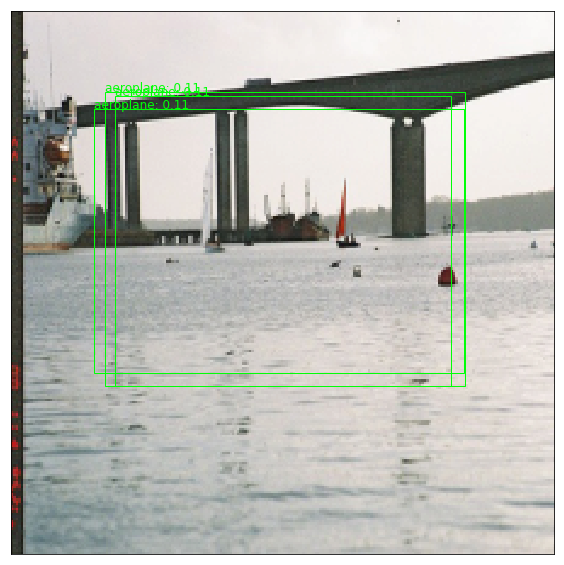

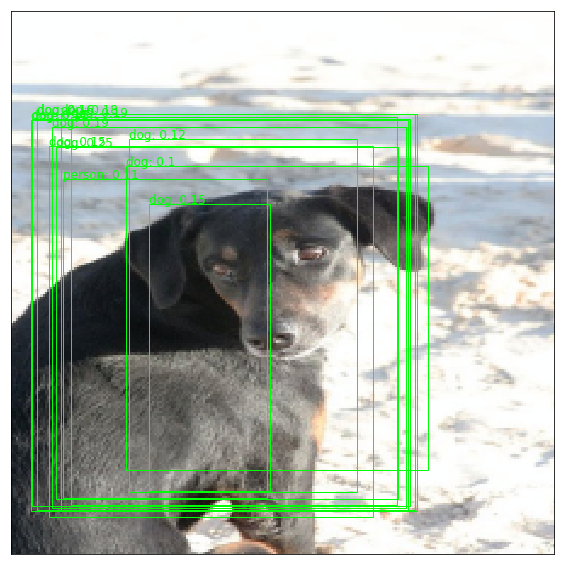

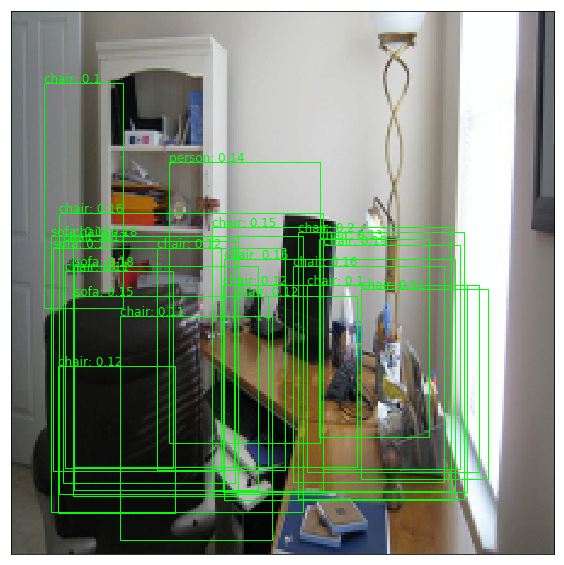

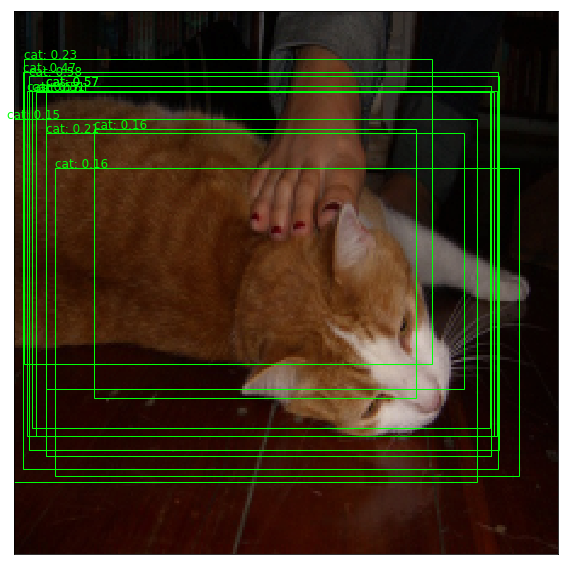

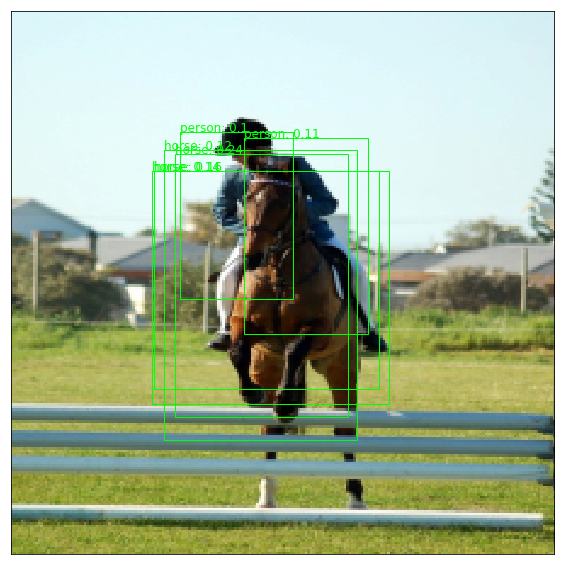

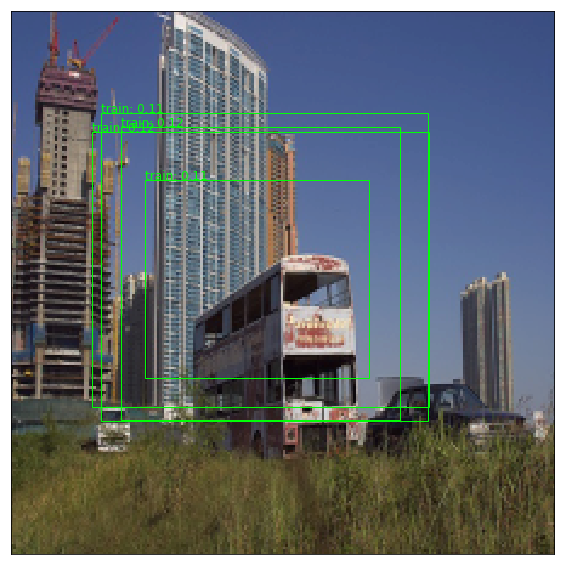

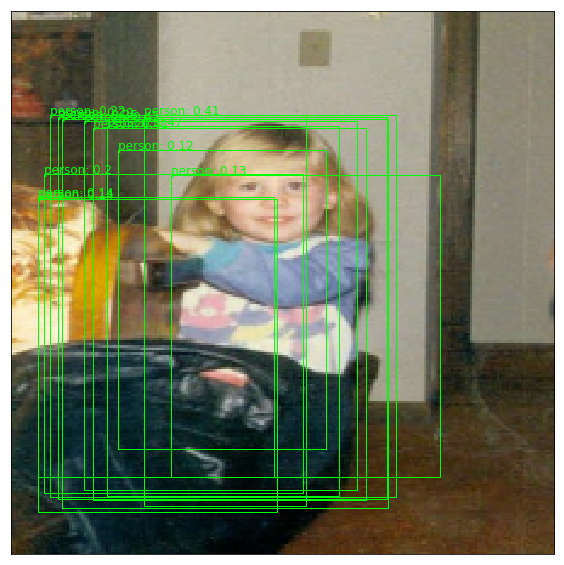

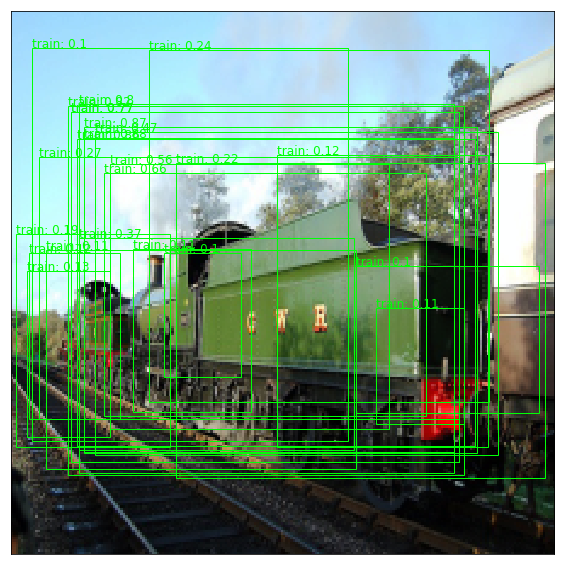

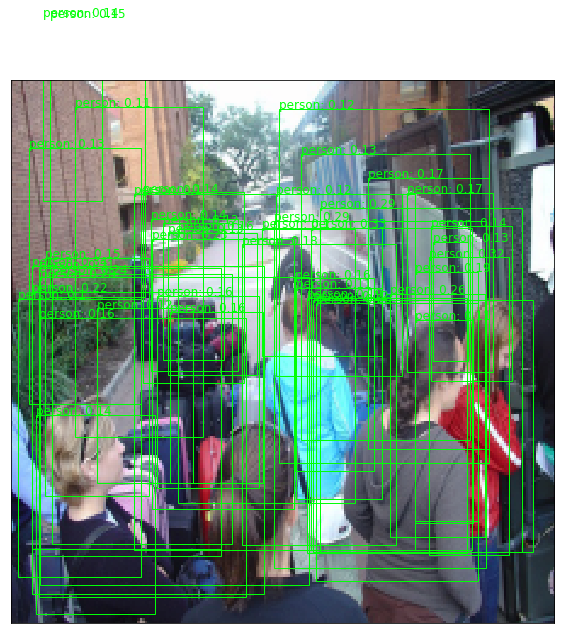

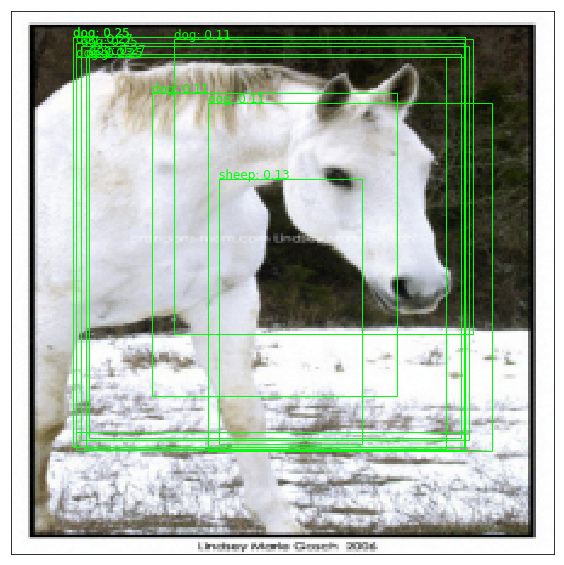

In [37]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.1, use_nms=False)

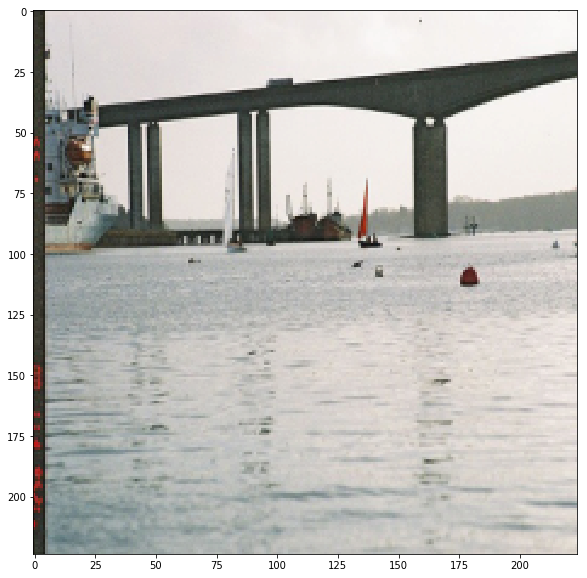

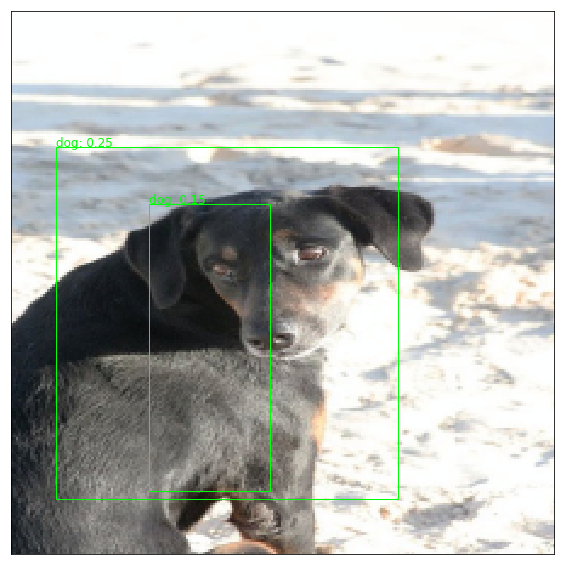

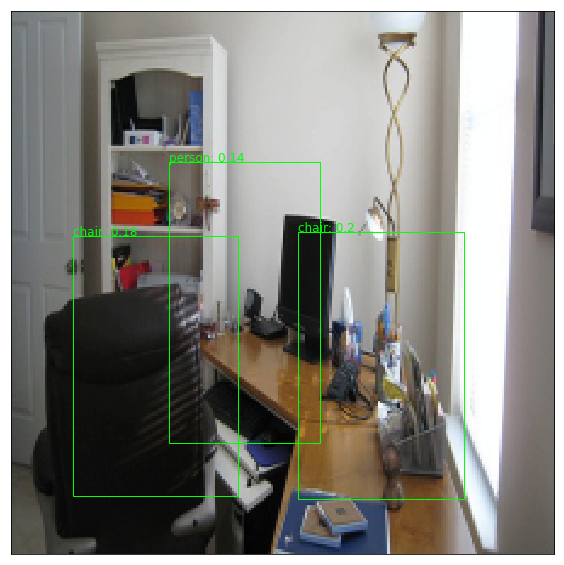

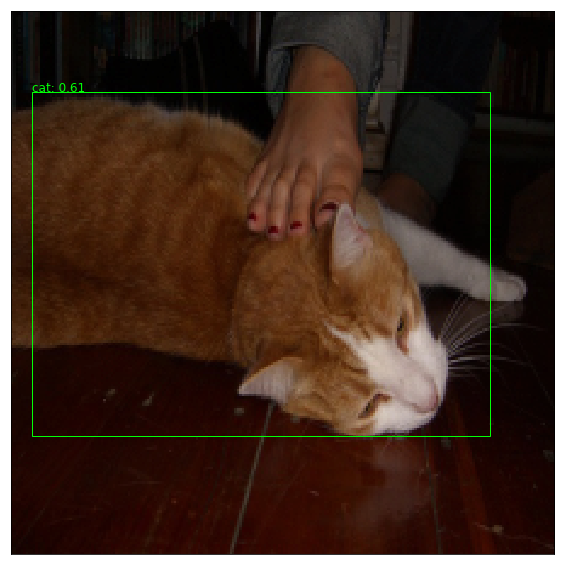

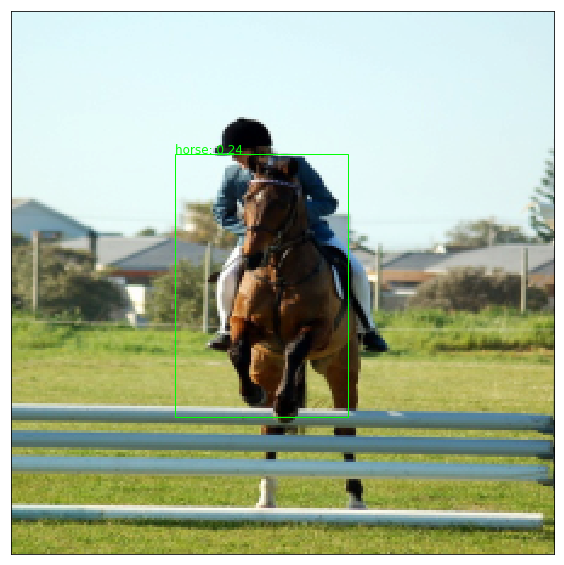

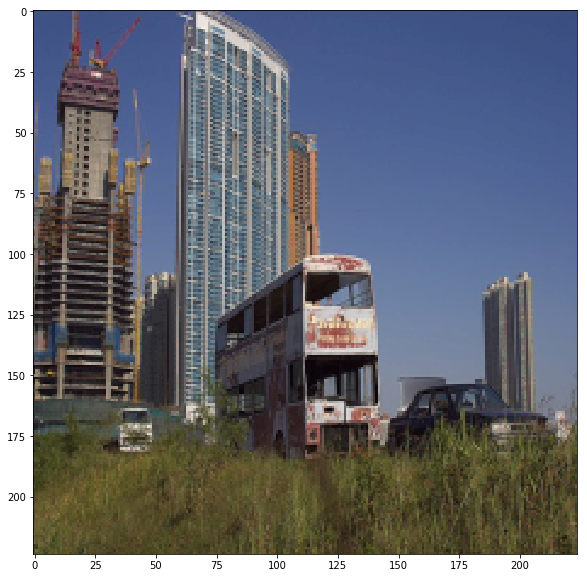

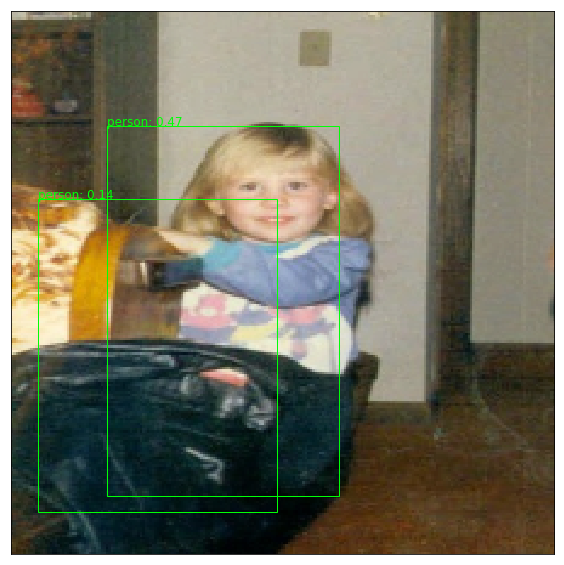

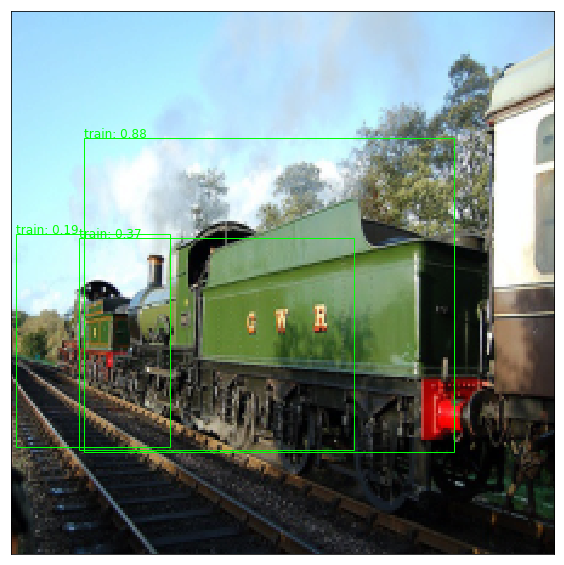

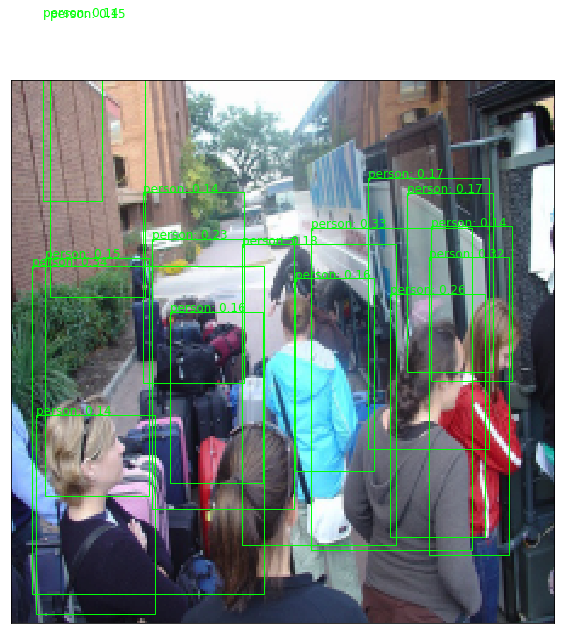

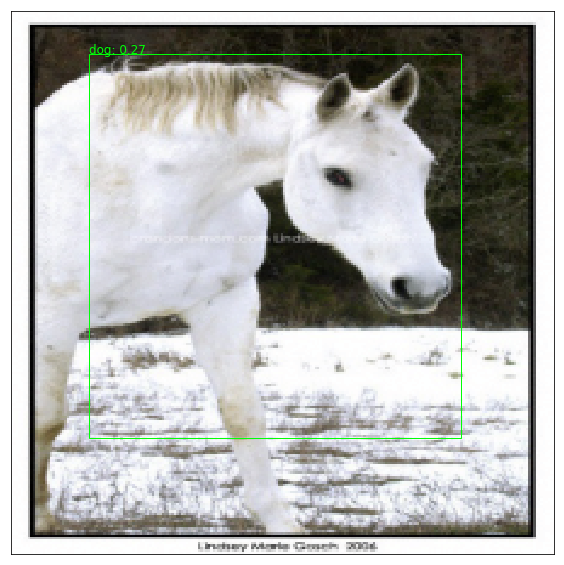

In [38]:
for im, bb, lab in zip(denormed_ims, bb_to_plot, lab_to_plot):
    voc.explore.plot_multiobject_results(im, bb, lab, pm_anc_tensor / 244, label2class, threshold=0.13)